In [1]:
#uncomment this to see the names of the different configurations that can be loaded in
from config import *

fieldlist=[]
for info in field._registry:
    fieldlist.append(info.name)
print('Names of available configurations for fields:, ', fieldlist)

mosaiclist=[]
for info in mosaic._registry:
    mosaiclist.append(info.name)
print('\nNames of available configurations for mosaics:, ', mosaiclist)

Names of available configurations for fields:,  ['Field1', 'Field2', 'Field3', 'Field5', 'Field6', 'Field7', 'Field8', 'Field9', 'Field10', 'Field11', 'Field12', 'Field13', 'FieldA', 'FieldB', 'FieldC', 'FieldD', 'FieldE', 'FieldF', 'FieldG', 'FieldH', 'FieldI', 'FieldK', 'FieldL', 'FieldM', 'FieldO', 'FieldP', 'FieldQ', 'FieldR', 'FieldS', 'FieldT', 'FieldU', 'FieldV', 'FieldW', 'FieldX', 'FieldY', 'H_North', 'H_South', 'ArchE', 'ArchNE', 'ArchNW', 'ArchSE', 'ArchW', 'FieldA9', 'FieldB9', 'FieldC9', 'FieldF9', 'FieldI9', 'FieldL9', 'FieldN9']

Names of available configurations for mosaics:,  ['Mosaic25', 'Mosaic37']


In [2]:
#import configuration for selected file
from config import FieldN9 as field
from config import wavelength, segdetsig, finddetsig, bkgbox #import additional common paramters
from config import dpath, dpathalt, ds9path #import additional common paramters

In [3]:
#import all required packages
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.table import Table
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join
from astropy.coordinates import SkyCoord

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry 
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground, SExtractorBackground, MMMBackground
from photutils.utils import calc_total_error

from regions import read_ds9

#newest stuff for psf photo
from photutils.psf import DAOGroup, IntegratedGaussianPRF
from astropy.modeling.fitting import LevMarLSQFitter
from photutils.psf import BasicPSFPhotometry
from photutils.datasets import make_gaussian_sources_image
from astropy.nddata import Cutout2D

In [131]:
def performApPhoto(data,tmap,wcs,sourceCoords,radii,rin,rout,plot=True):

	#create aperture objects for all specified radii 
	apertures =[SkyCircularAperture(sourceCoords, r=r*0.786*u.arcsec) for r in radii]

	#do aperture photometry on data using defined apertures 
	phot_table = aperture_photometry(data, apertures,wcs=wcs,error=errormap,method='exact')

	#now try photometry with local background subtraction
	#aperture2 =SkyCircularAperture(sourceCoords, r=radii[1]) #define aperture
	annulus_aperture = SkyCircularAnnulus(sourceCoords, r_in=rin*0.786*u.arcsec, r_out=rout*0.786*u.arcsec) #define annulus

	#convert to pixel coords for plotting
	pix_aperture = apertures[1].to_pixel(wcs)
	pix_annulus_aperture = annulus_aperture.to_pixel(wcs)
    

    
	#now lets do robust statistics on the background annuli
	#create lists to store information for later
	bkg_median=[]
	bkg_mean=[]
	bkg_std=[]
	appmasks=[]

	#create mask array for the annuli
	annulus_masks = pix_annulus_aperture.to_mask(method='exact')

	#for each of the annuli loop through and calculate stats using sigma cliped stats
	for mask in annulus_masks:
		annulus_data = mask.multiply(data)
		maskdata=mask.data
		#print(np.shape(mask))

		#do statistics
		annulus_data_1d = annulus_data[maskdata > 0]
		meansc, median_sigclip, stdsc = sigma_clipped_stats(annulus_data_1d)
		bkg_median.append(median_sigclip)
		bkg_mean.append(meansc)
		bkg_std.append(stdsc)
		appmasks.append(mask.data)

	#store values in numpy arrays
	bkg_median = np.array(bkg_median)
	bkg_mean = np.array(bkg_mean)
	bkg_std = np.array(bkg_std)

	#add columns for background information and also background subtracted apertures
	phot_table['ann_bkg_med'] = bkg_median
	phot_table['ann_bkg_mean'] = bkg_mean 
	phot_table['ann_bkg_std'] = bkg_std 


    
	#information from exposure time maps
	#create lists to store information for later
	texp_mean=[]
	texp_med=[]
	texpmasks=[]

	#create mask array for the exp time map apertures
	ap_masks = pix_aperture.to_mask(method='exact')

	#for each of the annuli loop through and calculate stats using sigma cliped stats
	for mask in ap_masks:
		ap_texp = mask.multiply(tmap)
        
		#do statistics
		ap_texp_1d = ap_texp[mask.data > 0]
		meansc, median_sigclip, stdsc = sigma_clipped_stats(ap_texp_1d)
		texp_med.append(median_sigclip)
		texp_mean.append(meansc)
		texpmasks.append(mask.data)

	phot_table['texp_med'] = texp_med
	phot_table['texp_mean'] = texp_mean
    
	#save these for later use
	phot_table['pixApArea']=pix_aperture.area
	phot_table['pixAnnArea']=pix_annulus_aperture.area

    
    
	if plot:
		#show figure with apertures overlayed
		plt.figure(figsize=(8,8))
		norm = simple_norm(data, 'sqrt', percent=99)
		plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
		plt.colorbar()
		#plt.xlim(40, 140)
		#plt.ylim(50, 125)

		ap_patches = pix_aperture.plot(color='white', lw=2,
	                          label='Photometry aperture')
		ann_patches = pix_annulus_aperture.plot(color='red', lw=2,
		                                    label='Background annulus')
		handles = (ap_patches[0], ann_patches[0])
		plt.legend(loc='best', facecolor='#458989', labelcolor='white',
		           handles=handles, prop={'weight': 'bold', 'size': 11})
		plt.show()

	'''  #still needs working out....
	#save these for later use
	for i in range(0,len(radii)):
		cname1='aperture_sum_'+str[i]
		cname2='aperture_sum_err_'+str[i]
		newcol1='aper_sum_bkgsub_'+str(radii[i])+'pix'
		newcol2='aper_snr_'+str(radii[i])+'pix'
		      
		pixarea=pix_aperture.area*(radii[i]/radii[1])**2
		phot_table[newcol1]=(phot_table[cname1]/pixarea-phot_table['ann_bkg_med'])*pixarea
		phot_table[newcol2]=phot_table[newcol1]/np.sqrt(2*np.pi*(radii[i]*phot_table['ann_bkg_std']/merged_table[newcol1])**2+(header['ERRCALF']/header['CALFCTR'])**2+0.0025) 
		        
		rename1='aperture_sum_'+str(radii[i])+'pix'
		rename2='aperture_sum_err_'+str(radii[i])+'pix'
		merged_table.rename_column(cname1, rename1)
		merged_table.rename_column(cname2, rename2)
	'''
    
    
    
	return phot_table

In [113]:
def modTabCol2(merged_table):
	#merged_table.remove_columns(['xcenter','ycenter','xcenter_2','ycenter_2','sky_center_1','sky_center_2','aperture_sum','aperture_sum_err'])
	
	#rename some columns to avoid possible confusion
	merged_table.rename_column('aperture_sum_0', 'aperture_sum_4pix')
	merged_table.rename_column('aperture_sum_err_0', 'aperture_sum_err_4pix')
	merged_table.rename_column('aperture_sum_1', 'aperture_sum_7pix')
	merged_table.rename_column('aperture_sum_err_1', 'aperture_sum_err_7pix')
	merged_table.rename_column('aperture_sum_2', 'aperture_sum_12pix')
	merged_table.rename_column('aperture_sum_err_2', 'aperture_sum_err_12pix')
	
	#compute area for the different size apertures 
	ap4pixarea=merged_table['pixApArea']*(4/7.)**2
	ap7pixarea=merged_table['pixApArea']*(7/7.)**2
	ap12pixarea=merged_table['pixApArea']*(12/7.)**2
	
		#calculate local bkg subtracted photometry for the other apertures 
	merged_table['aper_sum_bkgsub_4pix']=(merged_table['aperture_sum_4pix']/ap4pixarea-merged_table['ann_bkg_med'])*ap4pixarea
	merged_table['aper_sum_bkgsub_7pix']=(merged_table['aperture_sum_7pix']/ap7pixarea-merged_table['ann_bkg_med'])*ap7pixarea
	merged_table['aper_sum_bkgsub_12pix']=(merged_table['aperture_sum_12pix']/ap12pixarea-merged_table['ann_bkg_med'])*ap12pixarea
	
	#calculate snr for each aperture - updated using https://sofia-data-analysis-cookbooks.readthedocs.io/en/latest/FORCAST-photometry_detailed.html
	merged_table['aper_snr_4pix']=merged_table['aper_sum_bkgsub_4pix']/np.sqrt(2*np.pi*(4*merged_table['ann_bkg_std']/merged_table['aper_sum_bkgsub_4pix'])**2+(header['ERRCALF']/header['CALFCTR'])**2+0.0025) 
	merged_table['aper_snr_7pix']=merged_table['aper_sum_bkgsub_7pix']/np.sqrt(2*np.pi*(7*merged_table['ann_bkg_std']/merged_table['aper_sum_bkgsub_7pix'])**2+(header['ERRCALF']/header['CALFCTR'])**2+0.0025)
	merged_table['aper_snr_12pix']=merged_table['aper_sum_bkgsub_12pix']/np.sqrt(2*np.pi*(12*merged_table['ann_bkg_std']/merged_table['aper_sum_bkgsub_12pix'])**2+(header['ERRCALF']/header['CALFCTR'])**2+0.0025)
	
	
	
	#add additonal information for wavelength and which field 
	merged_table['Field']='C7'+field.name
	merged_table['wv']=wavelength
	
	#display table
	return merged_table

In [114]:
#change directory to data location - provide alternate if working between two different pc's
try:
    os.chdir(dpath)
except:
    os.chdir(dpathalt)

#import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
hdu=fits.open(field.filename)
header=hdu[0].header

#pull the first image plane
ims=hdu[0].data

#use the first image plane shape to determine how to unpack the rest of the data
if len(np.shape(ims))==2:
    data=ims
    varmap=hdu[1].data
    tmap=hdu[2].data
elif len(np.shape(ims))==3:
    data=ims[0]
    varmap=ims[1]
    tmap=ims[2]
    hdu[0].header['NAXIS']=2 #hack to make non-standard WCS work with astropy
hdu.close()

#define wcs object for header
wcsmap=WCS(hdu[0].header)

#create pixel error map by taking sqrt of variance map
errormap=np.sqrt(varmap)

In [115]:
#load in the catalog files if they exist
if os.path.isfile(field.name+'_'+str(wavelength)+'um_seg.fits'):
    segTab=Table.read(field.name+'_'+str(wavelength)+'um_seg.fits')
else:
    segTab=None
    
if os.path.isfile(field.name+'_'+str(wavelength)+'um_dao.fits'):   
    daoTab=Table.read(field.name+'_'+str(wavelength)+'um_dao.fits')
else:
    daoTab=None

In [116]:
#Get Source coordinates from table
if segTab is not None:
    sourcesseg=segTab['sky_centroid']
    
if daoTab is not None:
    sourcesdao=daoTab['sky_centroid']


In [117]:
#check if user defined ds9 file exists
if os.path.isfile(field.name+'_ds9.reg'):
    sourcesDS9=read_ds9(field.name+'_ds9.reg')

    clist=[]
    
    for source in sourcesDS9:
        if source.visual['color']=='green':
            sc=source.center
            ra=sc.ra.value
            dec=sc.dec.value
            a=(ra,dec)
            clist.append(a)
            
    ds9sc=SkyCoord(clist,unit=u.deg)
    usersources=True
    print('Number of user defined DS9 sources found: ', len(clist))  
else:
    usersources=False
    print('No user defined DS9 sources found')

No user defined DS9 sources found


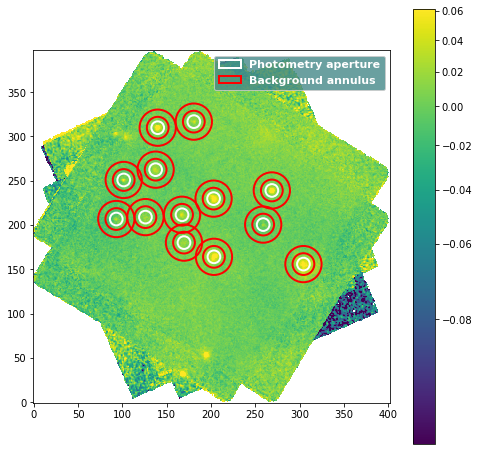

TypeError: 'type' object is not subscriptable

In [132]:
#radii = [2,4,6,8,10] #define aperture radii & construct apertures (line below) - old
#radii = [3.5,3.75,4.0,4.25,4.5,4.75,5,5.25,5.5,5.75,6.0,10] #define aperture radii & construct apertures (line below) - new

radii = [4,7,12] #aperture radii to use in photoemtry - units are pixels
r_in = 12  #inner radius for background annulus - units are pixels
r_out = 20  #outer radius for background annulus - units are pixels

if segTab is not None:
    SegPhotTable=performApPhoto(data,tmap,wcsmap,sourcesseg,radii,r_in,r_out,plot=True)

    #display the photometry table
    SegPhotTable
else:
    print('No sources found in segmentation map')

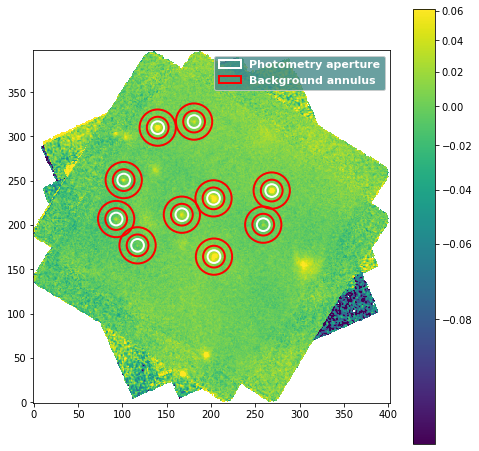

TypeError: 'type' object is not subscriptable

In [133]:
DaoPhotTable=performApPhoto(data,tmap,wcsmap,sourcesdao,radii,r_in,r_out,plot=True)

#display the table
DaoPhotTable

In [120]:
if usersources:
    UserPhotTable=performApPhoto(data,tmap,wcsmap,ds9sc,radii,plot=True) #changed for user sources
    
    #add sky_centriod to table
    UserPhotTable['sky_centroid']=ds9sc
    xs,ys=ds9sc.to_pixel(wcsmap)
    UserPhotTable['xcentroid']=xs
    UserPhotTable['ycentroid']=ys

    #display the table
    UserPhotTable

In [121]:
#fix id keywords in tables so theu can be merged
try:
    segTab.rename_column('label', 'id')
except:
    print('Do nothing because keyword is already changed.')

#try:
#    daoTab.rename_column('label', 'id')
#except:
#    print('Do nothing because keyword is already changed.')

In [122]:
#merge Tables
merged_table_seg = join(segTab, SegPhotTable, keys='id')
merged_table_dao = join(daoTab, DaoPhotTable, keys='id')

In [123]:
mtSeg=modTabCol2(merged_table_seg)
mtDao=modTabCol2(merged_table_dao)

if usersources:
    mtds9=modTabCol(UserPhotTable)


In [ ]:
#write out the resulting tables to file
ascii.write(mtSeg, field.name+'_'+str(wavelength)+'um_segCat.dat', overwrite=True)
ascii.write(mtDao, field.name+'_'+str(wavelength)+'um_daoCat.dat', overwrite=True)

if usersources:
    ascii.write(mtds9, field.name+'_'+str(wavelength)+'um_usrCat.dat', overwrite=True)

In [16]:
#new addition to include FWHM measurements for DAO
def doPSFphoto(image,bkgmodel,sourceTable,sigma_init,plotting=False): 
	 #create initial guess positions for fitting routine
	
	initTab=Table()
	initTab['x_0']=sourceTable['xcentroid']
	initTab['y_0']=sourceTable['ycentroid']
	initTab['flux']=sourceTable['aper_sum_bkgsub_5.0as']
	
	try:
		initTab['sigma_0']=sourceTable['fwhm']
	except:
		initTab['sigma_0']=2.5
	
	daogroup = DAOGroup(crit_separation=8)
	mmm_bkg = MedianBackground() #MedianBackground()#MMMBackground()
	fitter = LevMarLSQFitter()
	gaussian_prf = IntegratedGaussianPRF(sigma=sigma_init)
	gaussian_prf.sigma.fixed = False
	mmm_bkg.sigma_clip.fixed = False
	
	basic_phot_obj=BasicPSFPhotometry(group_maker=daogroup, bkg_estimator=mmm_bkg, psf_model=gaussian_prf, fitter=fitter, fitshape=(11, 11),extra_output_cols='sigma_unc')
	
	photB_results = basic_phot_obj(image,init_guesses=initTab) #must provide initial guesses as an astropy table with columns x_0 and y_0 in pixel coords
	
	results=photB_results
	#results=photB_results[photB_results['flux_fit']>0]
	#results=results[(results['sigma_fit']>0) & (results['sigma_fit']<14) ]
	
	sources = Table()
	sources['flux'] = results['flux_fit']
	sources['x_mean'] = results['x_fit']
	sources['y_mean'] = results['y_fit']
	sources['x_stddev'] = results['sigma_fit']
	sources['y_stddev'] = sources['x_stddev']
	#sources['theta'] = [0] * 2
	
	modelimage = make_gaussian_sources_image(np.shape(data), sources)
	
	#residual=data-modelimage
	residual=data-(modelimage+bkgmodel) #include bkg model   
	    
	chivals=[]
	
	for source in photB_results:
		spos=(np.int(source['x_fit']),np.int(source['y_fit']))
		cutout=Cutout2D(residual,spos,15)
		#print(np.sum(cutout.data))
		fudge=100.
		chivals.append((np.nansum(cutout.data)/21.)**2*100)
		
	results['psfFitChi']=chivals
	#print(chivals)
	
	#rename flux initial guess in table 
	results.rename_column('flux', 'flux_init')
	
	if plotting==True:
		#a few diagnostic plots to examine background contributions to aperture flux
		fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))
		
		ax1.set_title('Data')
		p1=ax1.imshow(data,origin='lower')
		fig.colorbar(p1, ax=ax1)
		
		
		ax2.set_title('Residual Map from DAOfind')
		p2=ax2.imshow(DAOresidual,origin='lower',vmin=-0.2,vmax=0.2)
		fig.colorbar(p2, ax=ax2)
	    
	sourceTable['PSF_fwhm']=results['sigma_fit']*2.355
	#sourceTable['PSF_fwhm_unc']=results['sigma_unc']*2.355
	sourceTable['PSF_Flux_1D']=results['flux_fit']
	#sourceTable['PSF_Flux_unc_1D']=results['flux_unc']
	sourceTable['psfFitChi']=results['psfFitChi']
	#sourceTable['psfSNR']=results['flux_fit']/photB_results['flux_unc']
	
	#return photB_results, residual#, chivals
	return sourceTable

In [17]:
#new addition to include FWHM measurements for DAO


#create background model for image using median method
bkg_estimator = MedianBackground() #MMMBackground() #SExtractorBackground() #MedianBackground()
bkg_data = Background2D(data,(bkgbox, bkgbox), filter_size=(3, 3),bkg_estimator=bkg_estimator,edge_method='pad') #smaller box?, 20x20, 25x25?
bkg_rms=bkg_data.background_rms
bkg=bkg_data.background 

#create background subtracted image
#data_bkgsub = data - bkg
data_bkgsub = np.nan_to_num(data - bkg)


#do psf model fits with 2d gaussian
mtDao=doPSFphoto(data_bkgsub,bkg,mtDao,2.0)
mtSeg=doPSFphoto(data_bkgsub,bkg,mtSeg,2.0)



C:\Users\MHANKI~1\AppData\Local\Temp/ipykernel_8788/3804868993.py:46: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  spos=(np.int(source['x_fit']),np.int(source['y_fit']))
C:\Users\MHANKI~1\AppData\Local\Temp/ipykernel_8788/3804868993.py:46: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current us

In [18]:
mtDao

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,sky_centroid,aperture_sum_3.5as,aperture_sum_err_3.5as,aperture_sum_3.75as,aperture_sum_err_3.75as,aperture_sum_4.0as,aperture_sum_err_4.0as,aperture_sum_4.25as,aperture_sum_err_4.25as,aperture_sum_4.5as,aperture_sum_err_4.5as,aperture_sum_4.75as,aperture_sum_err_4.75as,aperture_sum_5.0as,aperture_sum_err_5.0as,aperture_sum_5.25as,aperture_sum_err_5.25as,aperture_sum_5.5as,aperture_sum_err_5.5as,aperture_sum_5.75as,aperture_sum_err_5.75as,aperture_sum_6.0as,aperture_sum_err_6.0as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,ann_bkg_std,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,texp_med,texp_mean,pixApArea,pixAnnArea,aper_snr_6as,aper_sum_bkgsub_3.5as,aper_sum_bkgsub_3.75as,aper_sum_bkgsub_4.0as,aper_sum_bkgsub_4.25as,aper_sum_bkgsub_4.5as,aper_sum_bkgsub_4.75as,aper_sum_bkgsub_5.0as,aper_sum_bkgsub_5.25as,aper_sum_bkgsub_5.5as,aper_sum_bkgsub_5.75as,aper_sum_bkgsub_6.0as,aper_sum_bkgsub_10as,aper_snr_3.5as,aper_snr_3.75as,aper_snr_4.0as,aper_snr_4.25as,aper_snr_4.5as,aper_snr_4.75as,aper_snr_5.0as,aper_snr_5.25as,aper_snr_5.5as,aper_snr_5.75as,aper_snr_6.0as,aper_snr_10as,aper_snr_max,Field,wv,PSF_fwhm,PSF_Flux_1D,psfFitChi
,,,,,,,,,,,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str9,int32,float64,float64,float64
1,304,155.9,0.2981,0.09554,0.979,25,0,0.04602,1,-0.0003922,"266.02008285995663,-29.42245942942512",3.4975830784638635,0.8226263079949366,3.89057158743063,0.8815097220053878,4.293798891715966,0.9403807854515153,4.7097065124234625,0.999236581218992,5.126831824872342,1.0581020697179921,5.552157972732397,1.1169878500851596,5.990356829633104,1.1758645128029734,6.425450257073175,1.2346541444584747,6.861513208991575,1.2933915540172345,7.299542022616343,1.3521126943027493,7.734151614083581,1.410806504340591,14.25849742628332,2.3621589362160775,0.0031933057278598753,0.005252536925674104,0.008243012671151156,7.121842781415081,1.410806504340591,478.2879500000003,476.5091991519417,191.7476386073635,830.906433965242,119.08275207714131,3.289227989569721,3.6513884496694975,4.0216616327521875,4.402489059921385,4.782408106496311,5.168401916146758,5.565142362502201,5.956651307061355,6.347003703763182,6.737195889835724,7.121842781415081,12.557639557759712,52.7880515801424,59.02838452956286,65.42068671679608,72.01210566339203,78.5814336582606,85.26391420004116,92.14939495862244,98.93102934953684,105.68780554815204,112.43926226238403,119.08275207714131,211.59906066255272,211.59906066255272,C7FieldN9,25,10.679334141076895,7.814824599503777,0.14548044691693737
2,203.4,164.3,0.4041,0.9029,0.3245,25,0,0.09929,2.067,-0.7883,"266.044739408885,-29.420666448471252",4.018817616511276,0.7815218727577868,4.36771939182741,0.8374114660439985,4.704816137780642,0.8933254845946585,5.024643196596018,0.9492575069326729,5.345572947246954,1.0052117189860617,5.663500021817728,1.0613166743549132,5.964300363642526,1.1174910404314256,6.251743775911752,1.173717214521206,6.519094460824816,1.2300396330702337,6.768088151986365,1.2864188703501322,7.010530268801212,1.3427596245683011,10.563348553460196,2.2488321042033976,0.003927765710989389,0.004375418397009045,0.004457029822983097,6.257390468716023,1.3427596245683011,575.4245000000004,570.4461786544425,191.7476386073635,830.906433965242,109.63448829470465,3.7625408789822887,4.073524157419134,4.370087337742781,4.646765762178276,4.92193180

In [19]:
#write out the resulting tables to file
ascii.write(mtSeg, field.name+'_'+str(wavelength)+'um_segCat.dat', overwrite=True)
ascii.write(mtDao, field.name+'_'+str(wavelength)+'um_daoCat.dat', overwrite=True)

if usersources:
    ascii.write(mtds9, field.name+'_'+str(wavelength)+'um_usrCat.dat', overwrite=True)